In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
from esmpy.conf import DATASETS_PATH
from pathlib import Path
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse
from esmpy.utils import rescaled_DH

In [2]:
dataset_path = DATASETS_PATH / Path("FpBrgCaPv_N293_paper/sample_1.hspy")
true_spim = hs.load(str(dataset_path))
true_spectra = true_spim.phases
true_maps = true_spim.maps
k = len(true_spim.metadata.Truth.phases)
shape_2d = true_spim.shape_2d

fontsize = 30
scale = 15
aspect_ratio = 1.4
marker_list = ["-o","-s","->","-<","-^","-v","-d"]
mark_space = 20

# NMF

In [14]:
true_spim.decomposition(False,algorithm = "NMF", max_iter = 200000, tol = 1e-9, solver = "mu", beta_loss = "kullback-leibler", verbose = True, output_dimension = 3, init = "random", random_state = 52)

Epoch 10 reached after 17.171 seconds, error: 1232.249731
Epoch 20 reached after 33.283 seconds, error: 1229.664199
Epoch 30 reached after 50.486 seconds, error: 1228.781683
Epoch 40 reached after 67.747 seconds, error: 1228.282791
Epoch 50 reached after 85.597 seconds, error: 1227.940270
Epoch 60 reached after 104.374 seconds, error: 1227.678589
Epoch 70 reached after 123.859 seconds, error: 1227.475210
Epoch 80 reached after 142.038 seconds, error: 1227.315228
Epoch 90 reached after 158.980 seconds, error: 1227.201467
Epoch 100 reached after 175.894 seconds, error: 1227.114544
Epoch 110 reached after 193.453 seconds, error: 1227.040555
Epoch 120 reached after 214.387 seconds, error: 1226.989105
Epoch 130 reached after 232.309 seconds, error: 1226.947337
Epoch 140 reached after 250.110 seconds, error: 1226.910256
Epoch 150 reached after 268.153 seconds, error: 1226.880767
Epoch 160 reached after 286.211 seconds, error: 1226.854163
Epoch 170 reached after 304.981 seconds, error: 1226.8

In [15]:
factors = true_spim.get_decomposition_factors().data.T
loadings = true_spim.get_decomposition_loadings().data.reshape((3,16384))

r_factors, r_loadings = rescaled_DH(factors,loadings)

# ICA

In [8]:
true_spim.decomposition(True,output_dimension = 3,random_state = 42)
true_spim.blind_source_separation(number_of_components=3,tol = 1e-9)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=3
  centre=None
[########################################] | 100% Completed |  0.2s


Blind source separation info:
  number_of_components=3
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-09, whiten=False)


In [10]:
factors = true_spim.get_bss_factors().data.T
loadings = true_spim.get_bss_loadings().data.reshape((3,16384))

r_factors, r_loadings = rescaled_DH(factors,loadings)

(1980, 3) (3, 16384)


# VCA

In [7]:
from VCA import vca
from sunsal import sunsal

r_factors, a, b = vca(true_spim.X, 3)
r_loadings, c, d, e = sunsal(r_factors,true_spim.X,positivity=True, addone = True, tol = 1e-9) 

SNR estimated = 5.070236509660555[dB]
... Select proj. to R-1


# MCRLLM

In [ ]:
from snmfem.estimators.mcrllm_wrapper import MCRLLM

estimator = MCRLLM(n_components=3, init="Kmeans", tol = 1e-4, max_iter=20000,hspy_comp=True)

true_spim.decomposition(algorithm=estimator,verbose=True)

In [ ]:
factors = true_spim.get_decomposition_factors().data.T
loadings = true_spim.get_decomposition_loadings().data.reshape((3,16384))

r_factors, r_loadings = rescaled_DA(factors,loadings)

# Results

In [9]:
angles, true_inds = find_min_angle(true_spectra.T, r_factors.T, unique=True, get_ind=True)
mse = ordered_mse(true_maps, r_loadings, true_inds)

print("angles : ", angles)
print("mse : ", mse)

angles :  [8.814477090686905, 30.23130274815638, 53.32976341424424]
mse :  [0.24194431774118708, 0.1411757994928663, 0.7445883567061391]


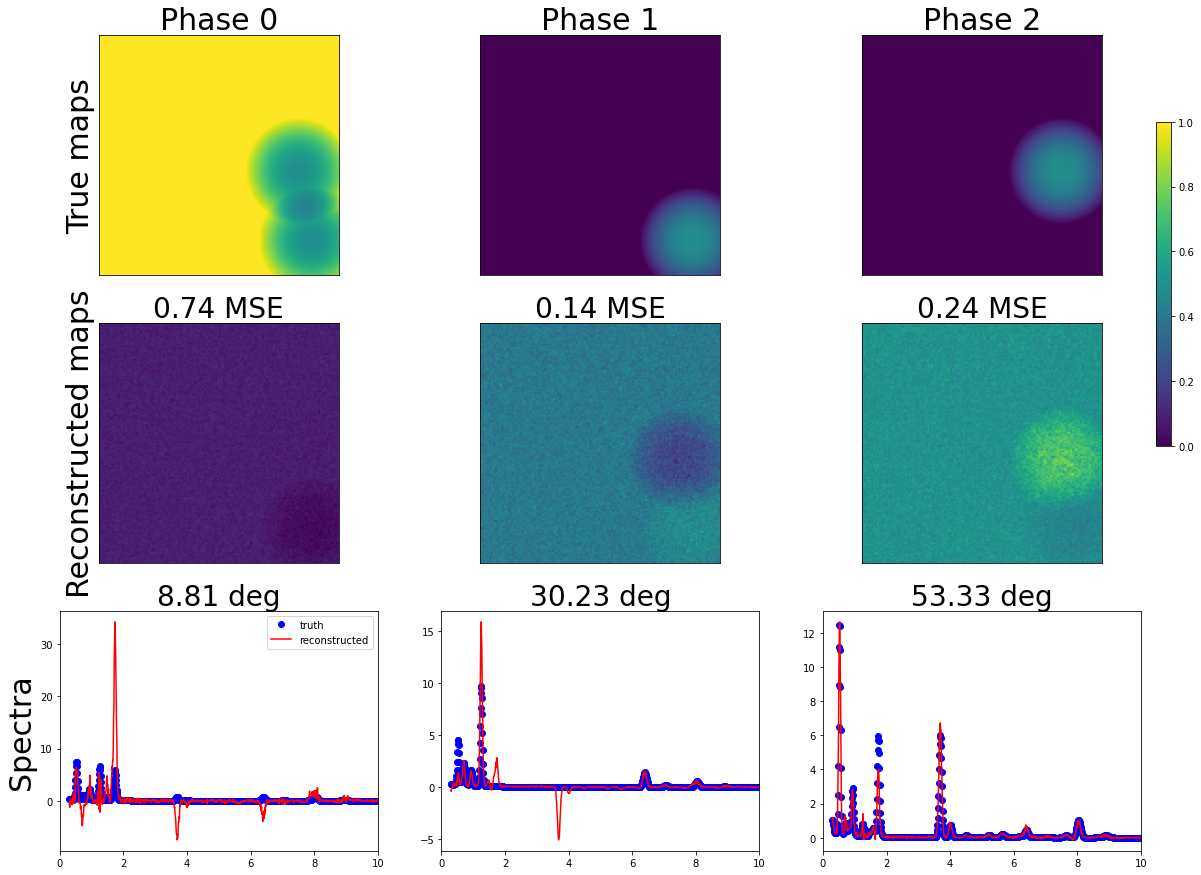

In [7]:
fig, axes = plt.subplots(k,3,figsize = (scale/k * 3 * aspect_ratio,scale))
x = np.linspace(true_spim.axes_manager[2].offset,
                true_spim.axes_manager[2].offset + true_spim.axes_manager[2].scale * true_spim.axes_manager[2].size,
                num = true_spim.axes_manager[2].size)
for i in range(k): 
    axes[2,i].plot(x,true_spectra.T[i,:],'bo',label='truth',linewidth=4)
    axes[2,i].plot(x,r_factors[:,true_inds[i]],'r-',label='reconstructed',markersize=3.5)
    axes[2,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
    axes[2,i].set_xlim(0,10.0)

    axes[1,i].imshow((r_loadings[true_inds[i],:]).reshape(shape_2d),vmin = 0.0, vmax = 1.0 )
    axes[1,i].set_title("{:.2f} MSE".format(mse[true_inds[i]]),fontsize = fontsize-2)
    # axes[i,1].set_ylim(0.0,1.0)
    axes[1,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

    im = axes[0,i].imshow(true_maps[i].reshape(shape_2d),vmin = 0.0, vmax = 1.0)
    axes[0,i].set_title("Phase {}".format(i),fontsize = fontsize)
    axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
    axes[2,0].legend()

rows = ["True maps","Reconstructed maps","Spectra"]

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=fontsize)


fig.subplots_adjust(right=0.84)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.3])
fig.colorbar(im,cax=cbar_ax)

# fig.tight_layout()

plt.show()